# HarvestStat Data Analysis - Zimbabwe

## Validation with FAOSTAT and CHIRPS Precipitation

Main-Maize Correlation:
           FAO        HS      PRCP
FAO   1.000000  0.391773  0.102299
HS    0.391773  1.000000  0.380969
PRCP  0.102299  0.380969  1.000000


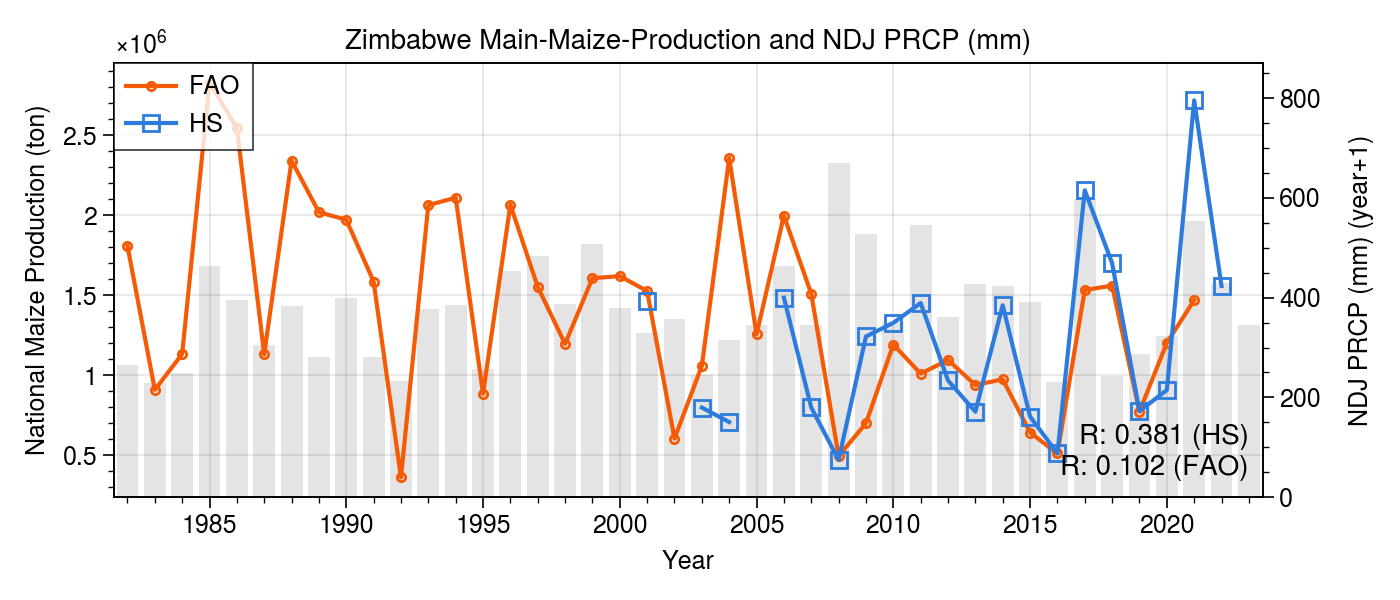

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import proplot as pplot
# Load Crop Data ------------------------------------- #
country_name, season_name, product_name_fdw, product_name_fao,  = 'Zimbabwe', 'Main', 'Maize', 'Maize (corn)'
shape_code, prcp_start_month, prcp_season_name, prcp_year_offset = 'ZW2011A0', 11, 'NDJ PRCP (mm)', +1
# HarvestStat
df = pd.read_csv('../public/hvstat_data.csv', index_col=0)
df = df[
    (df['country'] == country_name) &
    (df['season_name'] == season_name) &
    (df['product'].isin([product_name_fdw])) &
    (df['indicator'] == 'production')
].copy()
df['year'] = df['harvest_year']
data_hs = df.pivot_table(index='year',columns='product',values='value',aggfunc='sum').squeeze()
# FAO-STAT
df = pd.read_csv('../data/crop/adm_fao_stat.csv', index_col=0)
data_fao = df[
    (df['cnt_name'] == country_name) &
    (df['cpc2_name'] == product_name_fao) &
    (df['indicator'] == 'Production')
].set_index('year')['value']
# Merge
data = pd.concat([data_fao,data_hs], axis=1, keys=['FAO','HS']).sort_index()
data = data.reindex(np.array(range(1982,2024)))
# ---------------------------------------------------- #
# Load precipitation --------------------------------- #
fn = '../data/prcp_chirps-v2.hdf'
prcp_nat = pd.read_hdf(fn)[shape_code].resample('1M').agg('sum')
prcp_nat.index = prcp_nat.index.map(lambda x: x.replace(day=1))
prcp_nat.name = 'PRCP'
prcp_nat.index = prcp_nat.index + pd.DateOffset(years=prcp_year_offset)
# Forward rolling summation
indexer = pd.api.indexers.FixedForwardWindowIndexer(window_size=3)   # Forward Rolling Window
prcp_nat = prcp_nat.rolling(window=indexer, min_periods=3).sum()
prcp_nat = prcp_nat[prcp_nat.index.month == prcp_start_month]                      # Start month
prcp_nat = prcp_nat.groupby(prcp_nat.index.year).sum()
prcp_label = prcp_season_name
# Correlations
corr_value = pd.concat([data,prcp_nat],axis=1).corr()
print(f'{season_name}-{product_name_fdw} Correlation:\n{corr_value}')
# ---------------------------------------------------- #
# Comparison with Precipitation ---------------------- #
fig, ax1 = plt.subplots(figsize=(7,3))
fig.set_facecolor('white')
data.plot(ax=ax1, grid=True, markerfacecolor='None',color=['#F55A05','#2C7BDD'])
marker = ['.','s']
for i, line in enumerate(ax1.get_lines()):
    line.set_marker(marker[i])
# years = data.index
# ax1.set_xticks(years)
# ax1.set_xticklabels(['%02d'% yr for yr in np.mod(years,100)])
ax1.set_xlim([data.index[0]-0.5, data.index[-1]+0.5])
ax1.set_xlabel('Year')
ax1.set_ylabel('National %s Production (ton)' % product_name_fdw)
ax1.patch.set_facecolor('white')
# Precipitation
year, value = prcp_nat.index, prcp_nat.values
ax2 = ax1.twinx()
plt.bar(year, value, alpha=.25, color='grey')
ax2.set_ylim([0, value.max()*1.3])
ax2.set_ylabel(prcp_label + ' (year+%d)'%prcp_year_offset, labelpad=10)
ax2.grid(False)
ax1.set_zorder(1)  
ax1.patch.set_visible(False)  # prevents ax1 from hiding ax2
ax1.legend(loc='upper left')
ax1.annotate(
    'R: %.3f (HS)\nR: %.3f (FAO)' % (corr_value.loc['HS','PRCP'], corr_value.loc['FAO','PRCP']), 
    xy=(1, 0.2), xycoords='axes fraction', fontsize=10,
    xytext=(-5, -5), textcoords='offset points',
    ha='right', va='top'
)
title = f'{country_name} {season_name}-{product_name_fdw}-Production and {prcp_label}'
ax1.set_title(title)
fig.tight_layout()
plt.show()
# ---------------------------------------------------- #

## Report 1: Duplicates in the data

In [5]:
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'Zimbabwe',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
print(df.shape)

(0, 0)


In [9]:
df[
    (df['indicator'] == 'Quantity Produced') & 
    (df['product'] == 'Maize Grain (White)')
].pivot_table(index='fnid', columns='season_year', values='value', aggfunc='count')

season_year,Main harvest 2014,Main harvest 2015,Main harvest 2016,Main harvest 2018,Main harvest 2019,Main harvest 2020,Main harvest 2021
fnid,,,,,,,
ZW2011A21021,NaN,1.0,NaN,NaN,NaN,NaN,NaN
ZW2011A21101,1.0,1.0,2.0,1.0,1.0,1.0,1.0
ZW2011A21102,1.0,1.0,2.0,1.0,1.0,1.0,1.0
ZW2011A21103,1.0,1.0,2.0,NaN,NaN,1.0,1.0
ZW2011A21104,1.0,1.0,2.0,1.0,1.0,1.0,1.0
...,...,...,...,...,...,...,...
ZW2011A21803,1.0,1.0,2.0,1.0,1.0,1.0,1.0
ZW2011A21804,1.0,1.0,2.0,1.0,1.0,1.0,1.0
ZW2011A21805,1.0,1.0,2.0,NaN,NaN,1.0,1.0


In [8]:
df[
    (df['indicator'] == 'Quantity Produced') & 
    (df['product'] == 'Maize Grain (White)')
].pivot_table(index='season_year', columns='publication_name', values='value', aggfunc='count')

publication_name,"Ministry of Agriculture, Estimation Division, 2014, Zimbabwe","Ministry of Agriculture, Estimation Division, 2015, Zimbabwe","Ministry of Agriculture, Estimation Division, 2016, Zimbabwe","Ministry of Agriculture, Estimation Division, 2017, Zimbabwe","Ministry of Agriculture, Estimation Division, 2020, Zimbabwe","Ministry of Agriculture, Estimation Division, 2021, Zimbabwe","Second Round Crop and Livestock Assessment Report 2017/2018 season, Zimbabwe"
season_year,,,,,,,
Main harvest 2014,59.0,NaN,NaN,NaN,NaN,NaN,NaN
Main harvest 2015,NaN,62.0,NaN,NaN,NaN,NaN,NaN
Main harvest 2016,NaN,NaN,60.0,61.0,NaN,NaN,NaN
Main harvest 2018,NaN,NaN,NaN,NaN,NaN,NaN,49.0
Main harvest 2019,NaN,NaN,NaN,NaN,NaN,NaN,50.0
Main harvest 2020,NaN,NaN,NaN,NaN,61.0,NaN,NaN
Main harvest 2021,NaN,NaN,NaN,NaN,NaN,61.0,NaN


## Report 1: Year-off problem

In [1]:
# Reproduce the year-off problem in FDW-ZA crop data
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'South Africa',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# Remove national level values
df = df[df['fnid'] != 'ZA1994A0'].reset_index(drop=True)
# Table of "Maize Grain (Yellow)"
sub = df[
    (df['season_name'] == 'Summer') &
    (df['product'].isin(['Maize Grain (Yellow)'])) &
    (df['indicator'] == 'Quantity Produced')
]
sub.pivot_table(
    index=['start_date','period_date','season_name','season_type','season_date','season_year'],
    columns='product',values='value',aggfunc='sum'
).tail()

,,,,,product,Maize Grain (Yellow)
start_date,period_date,season_name,season_type,season_date,season_year,
2017-02-01,2017-02-28,Summer,Harvest,2016-10-01,Summer 2016,4283100.0
2017-04-01,2017-04-30,Summer,Harvest,2016-10-01,Summer 2016,4283100.0
2018-04-01,2018-04-30,Summer,Harvest,2017-10-01,Summer 2017,6904000.0
2019-04-01,2019-04-30,Summer,Harvest,2018-10-01,Summer 2018,6129650.0
2020-04-01,2020-04-30,Summer,Harvest,2019-10-01,Summer 2019,5648080.0


## Report 2: Duplication problem 

In [2]:
# Reproduce the year-off problem in FDW-ZA crop data
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'South Africa',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# Remove national level values
df = df[df['fnid'] != 'ZA1994A0'].reset_index(drop=True)
# Add "None" to undefined [publication_name]
df.loc[df['publication_name'] == '','publication_name'] = 'None'
# Table of "Maize Grain (Yellow)"
sub = df[
    (df['season_name'] == 'Summer') &
    (df['product'].isin(['Maize Grain (Yellow)'])) &
    (df['indicator'] == 'Quantity Produced')
]
sub.pivot_table(
    index=['start_date','period_date','season_date','season_year'],
    columns=['product','publication_name'],values='value',aggfunc='sum'
).tail()

product                                           Maize Grain (Yellow)  \
publication_name                               CEC, 2001, South Africa   
start_date period_date season_date season_year                           
2017-02-01 2017-02-28  2016-10-01  Summer 2016                     NaN   
2017-04-01 2017-04-30  2016-10-01  Summer 2016                     NaN   
2018-04-01 2018-04-30  2017-10-01  Summer 2017                     NaN   
2019-04-01 2019-04-30  2018-10-01  Summer 2018                     NaN   
2020-04-01 2020-04-30  2019-10-01  Summer 2019                     NaN   

product                                                                 \
publication_name                               CEC, 2016, South Africa   
start_date period_date season_date season_year                           
2017-02-01 2017-02-28  2016-10-01  Summer 2016               4283100.0   
2017-04-01 2017-04-30  2016-10-01  Summer 2016                     NaN   
2018-04-01 2018-04-30  2017-10-01  Summer 2017                     NaN   
2019-04-01 2019-04-30  2018-10-01  Summer 2018                     NaN   
2020-04-01 2020-04-30  2019-10-01  Summer 2019                     NaN   

product                                                                \
publication_name                               FEWS NET, South Africa   
start_date period_date season_date season_year                          
2017-02-01 2017-02-28  2016-10-01  Summer 2016                    NaN   
2017-04-01 2017-04-30  2016-10-01  Summer 2016                    NaN   
2018-04-01 2018-04-30  2017-10-01  Summer 2017                    NaN   
2019-04-01 2019-04-30  2018-10-01  Summer 2018                    NaN   
2020-04-01 2020-04-30  2019-10-01  Summer 2019                    NaN   

product                                                    \
publication_name                                     None   
start_date period_date season_date season_year              
2017-02-01 2017-02-28  2016-10-01  Summer 2016        NaN   
2017-04-01 2017-04-30  2016-10-01  Summer 2016  4283100.0   
2018-04-01 2018-04-30  2017-10-01  Summer 2017  6904000.0   
2019-04-01 2019-04-30  2018-10-01  Summer 2018  6129650.0   
2020-04-01 2020-04-30  2019-10-01  Summer 2019  5648080.0   

product                                                                               
publication_name                               Official Database, 2016, South Africa  
start_date period_date season_date season_year                                        
2017-02-01 2017-02-28  2016-10-01  Summer 2016                                   NaN  
2017-04-01 2017-04-30  2016-10-01  Summer 2016                                   NaN  
2018-04-01 2018-04-30  2017-10-01  Summer 2017                                   NaN  
2019-04-01 2019-04-30  2018-10-01  Summer 2018                                   NaN  
2020-04-01 2020-04-30  2019-10-01  Summer 2019                                   NaN

## Report 3: Duplication between products

In [3]:
# Reproduce the year-off problem in FDW-ZA crop data
import json, requests
import pandas as pd
host = 'https://fdw.fews.net'
auth = tuple(json.loads(open('token.json', "r").read()))
parameters = {
    'format': 'json',
    'country': 'South Africa',
    'product': 'R011',
    'survey_type': 'crop:best'
}
endpoint = '/api/cropproductionindicatorvalue/'
response = requests.get(host + endpoint, auth=auth, params=parameters, proxies={})
response.raise_for_status()
df = pd.DataFrame.from_records(response.json())
# Remove national level values
df = df[df['fnid'] != 'ZA1994A0'].reset_index(drop=True)
# Table of all products
sub = df[
    (df['season_name'] == 'Summer') &
    (df['indicator'] == 'Quantity Produced')
]
sub.pivot_table(
    index=['start_date','period_date','season_name','season_type','season_date','season_year'],
    columns='product',values='value',aggfunc='sum'
).tail(25)

,,,,,product,Maize Grain (White),Maize Grain (Yellow),Sorghum,Wheat Grain
start_date,period_date,season_name,season_type,season_date,season_year,,,,
2007-02-01,2007-02-28,Summer,Harvest,2006-10-01,Summer 2006,4038900.0,2430600.0,NaN,96000.0
2007-04-01,2007-04-30,Summer,Harvest,2006-10-01,Summer 2006,4038900.0,2430600.0,96000.0,NaN
2008-02-01,2008-02-29,Summer,Harvest,2007-10-01,Summer 2007,4315000.0,2810000.0,NaN,169700.0
2008-04-01,2008-04-30,Summer,Harvest,2007-10-01,Summer 2007,4315000.0,2810000.0,169700.0,NaN
2009-02-01,2009-02-28,Summer,Harvest,2008-10-01,Summer 2008,7480000.0,5220000.0,NaN,255000.0
2009-04-01,2009-04-30,Summer,Harvest,2008-10-01,Summer 2008,7480000.0,5220000.0,255000.0,NaN
2010-02-01,2010-02-28,Summer,Harvest,2009-10-01,Summer 2009,6775000.0,5275000.0,NaN,276500.0
2010-04-01,2010-04-30,Summer,Harvest,2009-10-01,Summer 2009,6775000.0,5275000.0,276500.0,NaN
2011-02-01,2011-02-28,Summer,Harvest,2010-10-01,Summer 2010,7830000.0,4985000.0,NaN,196500.0
